### Introduction/Setup

##### In this notebook, you will be guided through some of the code in this codebase, with the aim of demonstrating how node embedding algorithms can be used to represent networks by learning a vector representation for each node, and how these representations can also be applied downstream to perform machine-learning tasks on networks.

##### It is highly recommended that you use a virtual environment (e.g. Pyenv or Conda) to manage package versions. As of July 2025, this codebase runs using Python 3.11.9. Please refer to the requirements.txt file on the github repo to find all required dependencies.

##### Now that all the required packages are downloaded, let's load the ones that we'll directly use in this notebook:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### Generating the Network

##### The network we will use will be generated from a Stochastic Block Model (SBM), which is a class of networks where:
##### - Each node belongs to one of K possible node classes
##### - For any 2 classes, a probability is specified, namely, the probability of there being an edge between nodes of those 2 classes. In other words, the probability of an edge between two nodes is dependent only on the classes which the nodes belong to.

##### For this example, we have K=3 node classes. We also set the probability of an edge connection between nodes in different classes to be 0.1, and the probability of an edge connection between two nodes both in class 1 (or class 2, or class 3) to be the command line arguments p1, p2, & p3 respectively.

##### For ease of visualization, our network will only have 100 nodes, but improved performance on downstream tasks may be improved by using more (e.g. 500 or 1000) nodes.

In [38]:
# p1, p2, and p3 are the within-class edge probabilities for class 1, 2, and 3 respectively

!python -u sbm_simulator.py -p1 0.5 -p2 0.7 -p3 0.9

### Visualizing the Network

##### Now that we have simulated our SBM network, we visualize it below. Each node colour represents a node class, and the darker the edges appear to be, the more edges there are in that region.

##### Above, we specified the within-class edge probabilities to be 0.5, 0.7, & 0.9. In the plot below, you should be able to see this distinction with one of the classes having more edges between its nodes than the others.

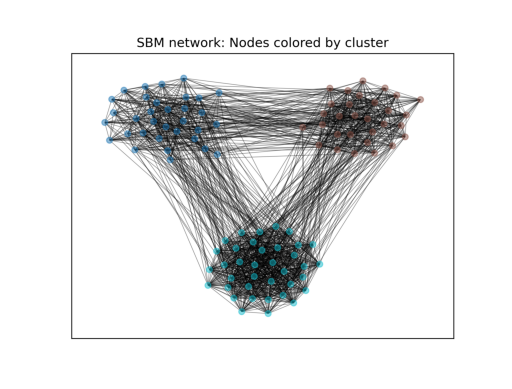

In [ ]:
%matplotlib inline

img = mpimg.imread("sbm.png")
plt.imshow(img)
plt.axis('off')
plt.show()

### Obtaining the Node Embeddings

##### <u>Note:</u> For all the embedding methods, except Spectral Clustering, we will use node embeddings which have 128 dimensions. This is to allow fair comparisons of results across methods, and also since 128 dimensions seems to work well for these methods in practice. For Spectral Clustering, since we know the network was generated by an SBM with 3 clear classes, a good choice for the number of dimensions is 3, as 128 dimensions may cause the method to overfit to noise in the data.

#### Spectral Clustering

##### The first method we will use for learning node embeddings is Spectral Clustering. It learns the embeddings using the eigenvectors of the network's laplacian matrix. The laplacian matrix is simply the degree matrix minus the adjacency matrix.

##### More specifically, Spectral Clustering takes the K (K = number of classes) smallest eigenvectors (smallest regarding the size of their associated eigenvalues), excluding the trivial eigenvector. This results in K eigenvectors of length n (n = number of nodes) which are then horizontally concatenated into an n x K matrix. Finally, each row of this matrix is the embedding for the corresponding node.

##### The node embeddings learned by Spectral Clustering capture node proximity (whether two nodes are adjacent), a node's local neighbour structure, and global network structure. If the input network is generated from a SBM, Spectral Clustering, the vast majority of the time, learns embeddings that are very close to each other for nodes part of the same class.

##### Parameters:
#####   - dim=3 (fixed)

In [ ]:
## Learning node embeddings using Spectral Clustering
!python -u SpectralClusteringClassificationImplementation/spectral_clustering_train_classification.py

# Reading in the learned embeddings
spec_embeddings = pd.read_csv("SpectralClusteringClassificationImplementation/spectral_clustering_node_embeddings_classification.csv", header=None)
print(spec_embeddings)

            0         1         2
0   -0.044322  0.001174 -0.001907
1   -0.046181  0.001537 -0.000890
2   -0.040786  0.001993  0.001769
3   -0.043322  0.002693 -0.000951
4   -0.043645  0.001835  0.000264
..        ...       ...       ...
995  0.024574  0.042781  0.000361
996  0.025543  0.041508 -0.003531
997  0.026262  0.040715 -0.004569
998  0.024293  0.039888  0.001201
999  0.024746  0.040724 -0.000755

[1000 rows x 3 columns]


#### Node2Vec

##### The second method we will use is Node2Vec, a stochastic (i.e. non-deterministic) method which uses random walks across the network to learn node embeddings. With Node2Vec, two nodes will have similar embeddings if they tend to co-occur on short walks across the network. Node2Vec was inspired by the word2vec model used in natural language processing (NLP).

##### Using the default parameter settings (p=1, q=1), at any node during the random walk, (assuming the graph is unweighted), the probability of moving to an adjacent node is simply a uniform distribution over all adjacent nodes, (i.e. each adjacent node has the same probability). If the graph is weighted, the probability of moving to an adjacent node is the weight of the edge connecting to that node divided by the sum of the edge weights over all edges connected to the current node.

##### Moreover, we can change the parameters p and q to make the random walk biased. Increasing p increases the chance of returning to the node you just previously visited ("taking a step back"), and increasing q increases the chance of visiting nodes that are close to the node that you've just visited. We will be using the default parameter settings of p=1 and q=1.

##### Parameters:
#####   - dim=128 (fixed)
#####   - walk_length: length of each random walk<br> &emsp;- increasing it allows for global network structure to be factored into a node's embedding, whereas decreasing it focuses more on a node's local neighbourhood structure<br> &emsp;- increasing it increases the compute time and memory usage
#####   - num_walks: number of random walks to be done starting from each node<br> &emsp;- increasing it (up to a point, e.g. 10) allows diverse neighbourhood information to be captured<br> &emsp;- increasing it also increases compute time and memory usage
#####   - p: influences the chance of revisiting the node just previously visited in the random walk (see above)
#####   - q: influences the chance of visiting a node close to the node just visited in the random walk (see above)
#####   - window: used when training the embeddings, it is the max distance between pairs of nodes along a  walk that can influence each other's embeddings<br> &emsp;- increasing it can allow for global structure to be captured, but at the risk of over-smoothing the embeddings and increasing compute time and memory usage


In [ ]:
## Learning node embeddings using Node2vec
!python -u Node2vecClassificationImplementation/n2v_train_classification.py

# Reading in the learned embeddings
n2v_embeddings = pd.read_csv("Node2vecClassificationImplementation/n2v_node_embeddings_classification.txt", sep=" ", index_col=0, header=None)
print(n2v_embeddings)

Generating walks (CPU: 4): 100%|██████████████████| 2/2 [00:03<00:00,  1.61s/it]
          1         2         3         4         5         6         7    \
0                                                                           
150 -0.219972  0.057394 -0.184678  0.105497  0.321318 -0.077849  0.240267   
667  0.050387 -0.012135  0.088461  0.097972  0.202207 -0.352551  0.167202   
572  0.137402 -0.022708 -0.154767  0.063459 -0.082020 -0.101101  0.146601   
400  0.118025 -0.146020 -0.165561  0.155387  0.259944 -0.251172 -0.244948   
235  0.021913 -0.151874 -0.371157 -0.124174 -0.008053  0.064638 -0.126223   
..        ...       ...       ...       ...       ...       ...       ...   
910 -0.234188 -0.020258  0.059155 -0.084042  0.207520 -0.026665  0.133614   
747  0.009034 -0.001467  0.035075 -0.124834  0.099988 -0.248870  0.204574   
990  0.102896 -0.067153 -0.073219 -0.064587  0.340910  0.135282  0.093026   
851 -0.147244  0.027190  0.146020  0.031332  0.362395 -0.124532  0.20151

#### LINE

##### The next method we will use is LINE (Large-scale information network embeddings). LINE captures both whether nodes are adjacent (first-order proximity) and the similarity of their neighbourhoods / how many neighbours they have in common (second-order proximity), which is useful since in many applications you may want non-adjacent nodes who share many common neighbours to be encoded as being similar.

##### When incorporating first-order proximity, LINE learns to give similar embeddings to adjacent nodes, and different embeddings to non-adjacent ones. When incorportating second-order proximity, LINE essentially learns, for each node, a probability distribution over its neighbour nodes. Using this, LINE gives similar embeddings to nodes with many common neighbours, and different embeddings to those with very different neighbourhoods.

##### The final embeddings output by LINE are just the concatenation of the first-order proximity and second-order proximity embeddings.

##### Parameters:
#####   - dim=128 (fixed)
#####   - epochs: number of times to iterate over each node when learning the embeddings (since in practice the training process minimizes a logloss function)<br> &emsp;- increasing this can improve the embeddings, but increasing it too much can cause noise in the network to be over-emphasized, potentially worsening results in downstream tasks
#####   - batchsize: number of nodes used at once to update the embeddings (for gradient descent)
#####   - lr: learning rate, controls how aggresive the gradient descent process is<br> &emsp;- increasing it makes it more aggresive and potentially converge faster, but at the risk of missing/overshooting the optimum embeddings
#####   - neg: number of negative samples drawn for each pair of adjacent nodes; they are used to help ensure that the embeddings of non-adjacent nodes are different

In [ ]:
## Learning node embeddings using LINE
!python -u LINEClassificationImplementation/line_train_classification.py -epochs 10 -batchsize 512 -dim 64  # dim=64 is specified because this dim represents the dims for each order (1 and 2)

# Reading in the learned embeddings
line_embeddings = pd.read_csv("LINEClassificationImplementation/line_node_embeddings_classification.csv", header=None)
print(line_embeddings)

Reading edgelist file...
100%|███████████████████████████████| 183374/183374 [00:00<00:00, 557950.84it/s]
1/2. Building and sorting scaled probabilities for alias table...
100%|██████████████████████████████| 183374/183374 [00:00<00:00, 1284448.21it/s]
2/2. Building alias table...
1/2. Building and sorting scaled probabilities for alias table...
100%|████████████████████████████████████| 999/999 [00:00<00:00, 1153664.56it/s]
2/2. Building alias table...
Number of nodes: 1000

Training on cpu...

Epoch 0
100%|████████████████████████████████████████| 358/358 [00:01<00:00, 187.44it/s]
Epoch 1
100%|████████████████████████████████████████| 358/358 [00:01<00:00, 191.28it/s]
Epoch 2
100%|████████████████████████████████████████| 358/358 [00:01<00:00, 190.51it/s]
Epoch 3
100%|████████████████████████████████████████| 358/358 [00:01<00:00, 193.09it/s]
Epoch 4
100%|████████████████████████████████████████| 358/358 [00:01<00:00, 186.46it/s]
Epoch 5
100%|████████████████████████████████████████|

#### GraRep

##### Another method we will use is GraRep, which includes up to the K^th order-proximity in a node's embedding (i.e. info about other nodes within a distance of K, also called the K-hop neighbourhood). Unlike LINE, the use of higher order proximities allows for more global network structure to be encoded, which is useful for large complex networks.

##### GraRep first computes the normalized powers of the adjacency matrix, for each power up to K, which represents the probability of moving from one node to another in exactly k steps (k=1,...,K). Next, this matrix is transformed such that nodes which co-occur (on the same random walk) more often than expected (based on their marginals P<sub>k</sub>(i)) are given larger values in the matrix than those which co-occur less often. This is to prevent "hub nodes"/high degree nodes from influencing nodes' embeddings too much. 

##### Finally, this matrix is factored using Singular Value Decomposition (SVD) which essentially does dimensionality reduction on the previous matrix, thus filtering out noise and providing a meaningful lower dimensional representation for each node.

##### The lower dimensional representations for each k are concatenated together to obtain the final node embeddings.

##### Parameters:
#####   - dim=126 (fixed), can't use 128 since it isn't a multiple of order=6
#####   - order: highest power of the (normalized) adjacency matrix to use


In [ ]:
## Learning node embeddings using GraRep
!python -u GraRepClassificationImplementation/grarep_train_classification.py -order 6 -dim 21

# Reading in the learned embeddings
grarep_embeddings = pd.read_csv("GraRepClassificationImplementation/grarep_node_embeddings_classification.csv", index_col=0, header=0)
print(grarep_embeddings)

Reading edgelist file...
100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.68it/s]
            0         1         2         3         4         5         6  \
0   -1.389470 -0.010683 -0.000711 -0.153266  0.000059 -0.000426  0.000255   
1   -1.390248 -0.013341  0.003409 -0.002301 -0.001527 -0.001110 -0.003557   
2   -1.390248 -0.013270  0.002530  0.000995 -0.002068  0.000236 -0.001221   
3   -1.390248 -0.013954  0.001204  0.001209 -0.004607  0.003827 -0.004083   
4   -1.390248 -0.013820  0.003422  0.001316 -0.000845 -0.004729 -0.000682   
..        ...       ...       ...       ...       ...       ...       ...   
995 -1.390239  0.003991 -0.015592  0.000129 -0.001319 -0.000523 -0.001676   
996 -1.390239  0.004376 -0.015255 -0.000024 -0.000259  0.001665  0.003943   
997 -1.390239  0.004691 -0.015111 -0.000153  0.007423 -0.004515 -0.003259   
998 -1.390240  0.004171 -0.014688  0.000166  0.001483  0.002904 -0.002296   
999 -1.390239  0.004234 -0.015019  0.000260  0.

### Fitting the Logistic Regression Model

##### Now that we have used different methods to generate node embeddings, we can evaluate them by comparing their ability to recover a node's true class given only these embeddings. We will use a multiclass logistic regression model (like regular logistic regression but for more than 2 classes) to predict a node's class and we will do a train/test split to ensure the model doesn't overfit to the data it trains on, but instead captures the general signal/pattern between a node's embedding vector and its class.

#### Spectral Clustering

In [36]:
# Fitting the logistic regression model using the embeddings learned by Spectral Clustering
# as features/variables
!python -u SpectralClusteringClassificationImplementation/spectral_clustering_logistic_regression.py

#### Node2Vec

In [24]:
# Fitting the logistic regression model using the embeddings learned by Node2vec
# as features/variables
!python -u Node2vecClassificationImplementation/n2v_logistic_regression.py

#### LINE

In [28]:
# Fitting the logistic regression model using the embeddings learned by LINE
# as features/variables
!python -u LINEClassificationImplementation/line_logistic_regression.py

#### GraRep

In [29]:
# Fitting the logistic regression model using the embeddings learned by GraRep
# as features/variables
!python -u GraRepClassificationImplementation/grarep_logistic_regression.py

### Assessing the Performance

##### For each embedding method, we will compare each node's predicted class, from the logistic regression model, with its actual class. There are several ways to compare them, but here are the metrics we will use:
#####   - accuracy: the proportion of nodes where the predicted class equals the actual class
#####   = (macro) precision: the (average over all classes) proportion of nodes predicted as a certain class which are actually of that class
#####   - (macro) recall: the (average over all classes) proportion of nodes in a certain class which were correctly predicted as being in that class
#####   - (macro) f1-score: the (average over all classes) of the f1-score (see below defn) of each class
#####   - f1-score: the harmonic mean of the (regular) recall and (regular) precision; the harmonic mean is a type of mean/average which prefers lower values, in essence giving lower outputs when one of the terms (precision or recall) is significantly smaller than the other

#### Spectral Clustering

In [ ]:
# Printing some performance metrics for this logistic regression model
with open("SpectralClusteringClassificationImplementation/spectral_clustering_labels.pkl", "rb") as labels:
    spec_labels = pickle.load(labels)
spec_y_true, spec_y_pred = spec_labels["Actual labels (test)"], spec_labels["Predicted labels"]

# Definitions:
# - accuracy: the proportion of nodes where the predicted class equals the actual class
# = (macro) precision: the (average over all classes) proportion of nodes predicted as a certain class which actually are that class
# - (macro) recall: the (average over all classes) proportion of nodes in a certain class which were correctly predicted as being in that class
# - (macro) f1-score: the (average over all classes) of the f1-score (see below defn) of each class
# - f1-score: the harmonic mean of the (regular) recall and (regular) precision

print(f"Accuracy: {accuracy_score(spec_y_true, spec_y_pred):.2f}")
print(f"(Macro) F1-Score: {f1_score(spec_y_true, spec_y_pred, average='macro'):.2f}")
print(f"(Macro) Precision: {precision_score(spec_y_true, spec_y_pred, average='macro'):.2f}")
print(f"(Macro) Recall: {recall_score(spec_y_true, spec_y_pred, average='macro'):.2f}")

Accuracy: 1.00
(Macro) F1-Score: 1.00
(Macro) Precision: 1.00
(Macro) Recall: 1.00


#### Node2Vec

In [ ]:
# Printing some performance metrics for this logistic regression model
with open("Node2vecClassificationImplementation/n2v_labels_classification.pkl", "rb") as labels:
    n2v_labels = pickle.load(labels)
n2v_y_true, n2v_y_pred = n2v_labels["Actual labels (test)"], n2v_labels["Predicted labels"]

# Definitions:
# - accuracy: the proportion of nodes where the predicted class equals the actual class
# = (macro) precision: the (average over all classes) proportion of nodes predicted as a certain class which actually are that class
# - (macro) recall: the (average over all classes) proportion of nodes in a certain class which were correctly predicted as being in that class
# - (macro) f1-score: the (average over all classes) of the f1-score (see below defn) of each class
# - f1-score: the harmonic mean of the (regular) recall and (regular) precision

print(f"Accuracy: {accuracy_score(n2v_y_true, n2v_y_pred):.2f}")
print(f"(Macro) F1-Score: {f1_score(n2v_y_true, n2v_y_pred, average='macro'):.2f}")
print(f"(Macro) Precision: {precision_score(n2v_y_true, n2v_y_pred, average='macro'):.2f}")
print(f"(Macro) Recall: {recall_score(n2v_y_true, n2v_y_pred, average='macro'):.2f}")

Accuracy: 0.54
(Macro) F1-Score: 0.55
(Macro) Precision: 0.55
(Macro) Recall: 0.55


#### LINE

In [ ]:
# Printing some performance metrics for this logistic regression model
with open("LINEClassificationImplementation/line_labels_classification.pkl", "rb") as labels:
    line_labels = pickle.load(labels)
line_y_true, line_y_pred = line_labels["Actual labels (test)"], line_labels["Predicted labels"]

# Definitions:
# - accuracy: the proportion of nodes where the predicted class equals the actual class
# = (macro) precision: the (average over all classes) proportion of nodes predicted as a certain class which actually are that class
# - (macro) recall: the (average over all classes) proportion of nodes in a certain class which were correctly predicted as being in that class
# - (macro) f1-score: the (average over all classes) of the f1-score (see below defn) of each class
# - f1-score: the harmonic mean of the (regular) recall and (regular) precision

print(f"Accuracy: {accuracy_score(line_y_true, line_y_pred):.2f}")
print(f"(Macro) F1-Score: {f1_score(line_y_true, line_y_pred, average='macro'):.2f}")
print(f"(Macro) Precision: {precision_score(line_y_true, line_y_pred, average='macro'):.2f}")
print(f"(Macro) Recall: {recall_score(line_y_true, line_y_pred, average='macro'):.2f}")

Accuracy: 0.99
(Macro) F1-Score: 0.99
(Macro) Precision: 0.99
(Macro) Recall: 1.00


#### GraRep

In [ ]:
# Printing some performance metrics for this logistic regression model
with open("GraRepClassificationImplementation/grarep_labels_classification.pkl", "rb") as labels:
    grarep_labels = pickle.load(labels)
grarep_y_true, grarep_y_pred = grarep_labels["Actual labels (test)"], grarep_labels["Predicted labels"]

# Definitions:
# - accuracy: the proportion of nodes where the predicted class equals the actual class
# = (macro) precision: the (average over all classes) proportion of nodes predicted as a certain class which actually are that class
# - (macro) recall: the (average over all classes) proportion of nodes in a certain class which were correctly predicted as being in that class
# - (macro) f1-score: the (average over all classes) of the f1-score (see below defn) of each class
# - f1-score: the harmonic mean of the (regular) recall and (regular) precision

print(f"Accuracy: {accuracy_score(grarep_y_true, grarep_y_pred):.2f}")
print(f"(Macro) F1-Score: {f1_score(grarep_y_true, grarep_y_pred, average='macro'):.2f}")
print(f"(Macro) Precision: {precision_score(grarep_y_true, grarep_y_pred, average='macro'):.2f}")
print(f"(Macro) Recall: {recall_score(grarep_y_true, grarep_y_pred, average='macro'):.2f}")

Accuracy: 0.99
(Macro) F1-Score: 0.99
(Macro) Precision: 0.99
(Macro) Recall: 1.00


### Plotting Node Embeddings

#### Spectral Clustering

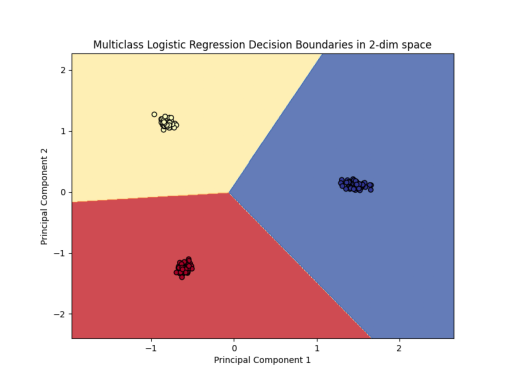

In [ ]:
!python -u SpectralClusteringClassificationImplementation/spectral_clustering_plot_embeddings_classification.py

%matplotlib inline

img = mpimg.imread("SpectralClusteringClassificationImplementation/spectral_clustering_pca_classification.png")
plt.imshow(img)
plt.axis('off')
plt.show()